## Classification using Deep Texture features and classic boundary features

In [1]:
import torch
import torchvision
import numpy as np
import utils
import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import utils

In [2]:
train_transformers = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.Normalize(std=1, mean=0),
    ToTensorV2()
])

In [3]:
train_dataset = datasets.TDSCForClassificationWithSub(transforms = train_transformers)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

tensor(1.) torch.Size([1, 224, 224]) 0.0


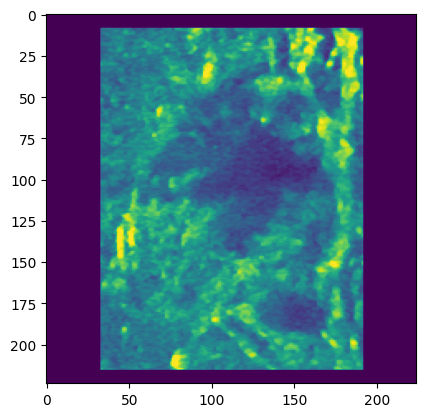

In [4]:
x, y = train_dataset[11]
print(x.max(), x.shape, y)

x = x[0,:,:].numpy()

plt.imshow(x)
plt.show()

In [5]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10

print(f"Using GPU? {'YES' if DEVICE == 'cuda' else 'NO'}")

Using GPU? YES


In [6]:
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES)
# Change the input layer to one channgel instead of 3 channel colored image
vgg16.features[0] = torch.nn.Conv2d(1,64,3)
# Modify the classifier output to be binary classification
num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = torch.nn.Linear(in_features=num_features, out_features=1)
vgg16 = vgg16.to(DEVICE)
optimizer = torch.optim.Adam(vgg16.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

In [8]:
for epoch in range(NUM_EPOCHS):
    data_loop = tqdm(dataloader)
    for data in data_loop:
        x, l = data
        x = x.to(DEVICE)
        l = l.unsqueeze(1).to(DEVICE)

        #Forward
        with torch.cuda.amp.autocast():
            predictions = vgg16(x)
            predictions = torch.nn.functional.sigmoid(predictions)
            loss = criterion(predictions, l)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        data_loop.set_postfix(loss=loss.item())

    utils.torch.calculate_accuracy(dataloader, vgg16, DEVICE)

torch.save(vgg16.state_dict(), "./checkpoint/vgg16-classification.pth")

  0%|          | 0/858 [00:00<?, ?it/s]

AttributeError: module 'utils' has no attribute 'calculate_accuracy'

## Using Signiture features

In [ ]:
class AnabolicClassifier(torch.nn.Module):
    
    def __init__(self, num_features):
        super(AnabolicClassifier, self).__init__()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(num_features, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,1)    
        )
                
    def forward(self, x):
        
        with torch.no_grad():
            texture_features = self.texture_feature_extractor(x)
            texture_features = torch.nn.Flatten()(x)

        inputs = torch.cat((texture_features, self.boundary_features(x)), dim=1)

        return self.classifier(inputs)
    

class AnabolicFeatures(torch.nn.Module):
    
    def __init__(self, texture_feature_extractor):
        super(AnabolicFeatures, self).__init__()
        self.texture_features = texture_feature_extractor
        
    def boundary_features(self, x):
        pass
    
    
    def forward(self, x):
        pass



In [46]:
classifier = AnabolicClassifier(vgg16.features).to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

In [47]:
# This model should be in evaluation mode and used as feature extractor
vgg16.eval()

for epoch in range(NUM_EPOCHS):
    for x,m,l in tqdm(dataloader):
        m = m.unsqueeze(1)
        x = (x - x * m * 0.3)
        l = l.unsqueeze(1).to(DEVICE)
        x = x.to(DEVICE)
                        
        with torch.cuda.amp.autocast():
            predictions = classifier(x)
            predictions = torch.nn.functional.sigmoid(predictions)
            loss = criterion(predictions, l)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        data_loop.set_postfix(loss=loss.item())
            

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]